In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group
import os
import sys
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from skimage.transform import AffineTransform, warp

In [3]:
def plot_gallery(list_images, h, w, n_row=3, n_col=6, flat_list = False):
    """Helper function to save a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row):
        for j in range(n_col):    
            plt.subplot(n_row, n_col, i * n_col + j + 1)
            if flat_list:
                plt.imshow(list_images[i*n_col + j].reshape((h, w)).numpy().astype(np.int), cmap='Greys')
            else:
                plt.imshow(list_images[j][i].reshape((h, w)).numpy().astype(np.int), cmap='Greys')
            plt.xticks(())
            plt.yticks(())

In [4]:
def draw_circle(img, inside=True, size_of_rect=20):
    
    s = np.random.sample(1)[0] * 0.8 + 0.2
    r = s * size_of_rect
    size = np.array(img.shape[:2])
    
    if inside:
        c = np.random.randint(r, size - r)
    else:
        c = np.random.randint(0, size)

    return cv2.circle(img, tuple(c), int(r), (1), 1), [r, c[0], c[1]]

In [5]:
def draw_square(img, inside=True, size_of_rect=20, pre_def = None):
    if not pre_def is None:
        a = np.array([1,  1], dtype=np.int) * pre_def[0] / np.sqrt(2)
        b = np.array([1, -1], dtype=np.int) * pre_def[0] / np.sqrt(2)
        c = np.array(pre_def[1:])
        s = pre_def[0]
        rect = np.expand_dims(np.vstack([c - a, c + b, c + a, c - b]), 1).astype(np.int32)
    else:
        s = (np.random.sample(1)[0] * 0.8 + 0.2) * size_of_rect
        a = np.array([1,  1], dtype=np.int) * s / np.sqrt(2)
        b = np.array([1, -1], dtype=np.int) * s/ np.sqrt(2)
        size = np.array(img.shape[:2])
        
        if inside:
            c = np.random.randint(np.maximum(abs(a), abs(b)), size - np.maximum(abs(a), abs(b)))
        else:
            c = np.random.randint(0, size)
        
        rect = np.expand_dims(np.vstack([c - a, c + b, c + a, c - b]), 1).astype(np.int32)
    return cv2.drawContours(img, [rect], 0, (1), 1), [s, c[0], c[1]]

In [6]:
class ImageDataset(Dataset):
    
    def __init__(self, draw_function, lenght = 512):
        super().__init__()
        self.lenght = lenght

        imgs  = [None] * lenght
        infos = [None] * lenght

        for i in range(lenght):
            img, r = draw_function(np.zeros((64, 64)))

            imgs[i] = torch.Tensor(img).flatten()
            infos[i] = torch.Tensor(r)
        
        self.imgs  = torch.vstack(imgs)
        self.infos = torch.vstack(infos)

    def __getitem__(self, idx):
        return self.imgs[idx], self.infos[idx]
    
    def __len__(self):
        # return len(self.data)
        return self.lenght

In [7]:
rect_data = ImageDataset(draw_square, lenght = 8192*10)
circ_data = ImageDataset(draw_circle, lenght = 8192)

rect_val_data = ImageDataset(draw_square, lenght = 512)
circ_val_data = ImageDataset(draw_circle, lenght = 512)

rect_loader = torch.utils.data.DataLoader(rect_data, batch_size=256)
circ_loader = torch.utils.data.DataLoader(circ_data, batch_size=256)

rect_val_loader = torch.utils.data.DataLoader(rect_val_data, batch_size=512)
circ_val_loader = torch.utils.data.DataLoader(circ_val_data, batch_size=512)
print(len(rect_data), len(rect_loader))

rect_image_h = 64
rect_image_w = 64

81920 320


In [9]:
from sklearn.decomposition import PCA

X_all = torch.vstack([rect_data.imgs[:8192], circ_data.imgs]).numpy()
X_rect = rect_data.imgs.numpy()
# X_circ = circ_data.imgs.numpy()

pca_all, pca_rect, pca_circ = PCA(n_components=2), PCA(n_components=2), PCA(n_components=2)
pca_all.fit(X_all); pca_rect.fit(X_rect)#; pca_circ.fit(X_circ)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

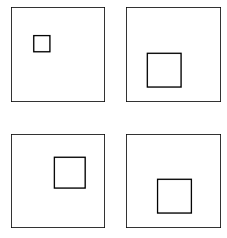

In [10]:
plot_gallery(next(iter(rect_loader))[0], rect_image_h, rect_image_w, n_row = 2, n_col = 2, flat_list = True)

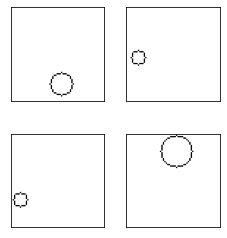

In [11]:
plot_gallery(next(iter(circ_loader))[0], rect_image_h, rect_image_w, n_row = 2, n_col = 2, flat_list = True)

In [13]:
image = rect_data.imgs[1].reshape(64, 64)
transform = AffineTransform(translation=(30,10))
wrapShift = warp(image,transform,mode='wrap')

In [14]:
image = draw_square(np.zeros((64, 64)), pre_def=[10, 8, 8])[0]
warped_permit = []
for i in range(-48, 1):
    for j in range(-48, 1):
        transform = AffineTransform(translation=(i,j))
        warped_permit.append(warp(image,transform,mode='wrap').reshape(-1))

In [15]:
image = draw_square(np.zeros((64, 64)), pre_def=[10, 8, 8])[0]
warped_all = []
for i in range(64):
    for j in range(64):
        transform = AffineTransform(translation=(i,j))
        warped_all.append(warp(image,transform,mode='wrap').reshape(-1))

In [16]:
image = draw_square(np.zeros((64, 64)), pre_def=[10, 8, 8])[0]
warped_all_2 = []
for j in range(64):
    for i in range(64):
        transform = AffineTransform(translation=(i,j))
        warped_all_2.append(warp(image,transform,mode='wrap').reshape(-1))

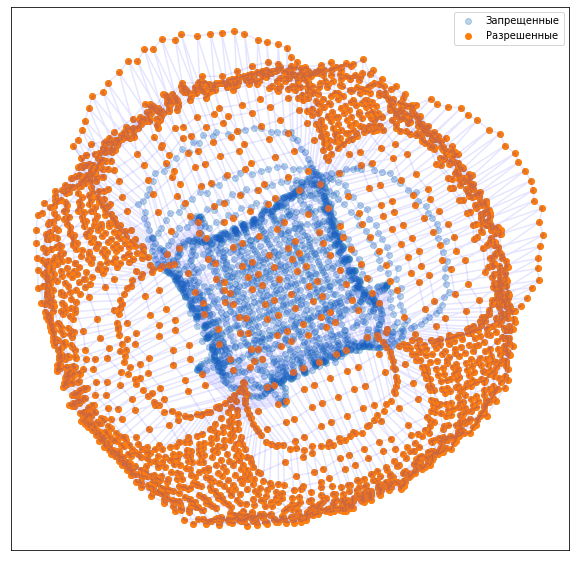

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

res = pca_rect.transform(np.vstack(warped_all))
plt.scatter(res[:, 0], res[:, 1], alpha=0.3, label='Запрещенные')
plt.plot(res[:, 0], res[:, 1], alpha=0.1, c='b')
res = pca_rect.transform(np.vstack(warped_all_2))
plt.plot(res[:, 0], res[:, 1], alpha=0.1, c='b')
res = pca_rect.transform(np.vstack(warped_permit))
plt.scatter(res[:, 0], res[:, 1], label='Разрешенные')

ax.legend()
# ax.grid(True)
plt.xticks(())
plt.yticks(())

plt.show()

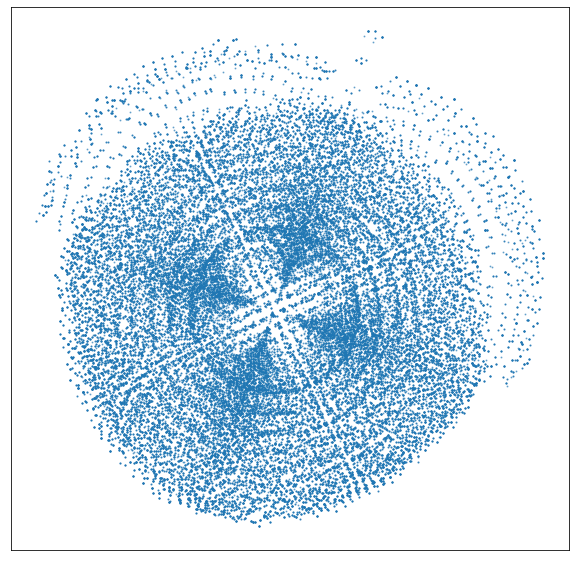

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

res = pca_rect.transform(X_rect)
plt.scatter(res[:, 0], res[:, 1], alpha=0.5, label='', s=1)

# ax.legend()
# ax.grid(True)
plt.xticks(())
plt.yticks(())

plt.show()

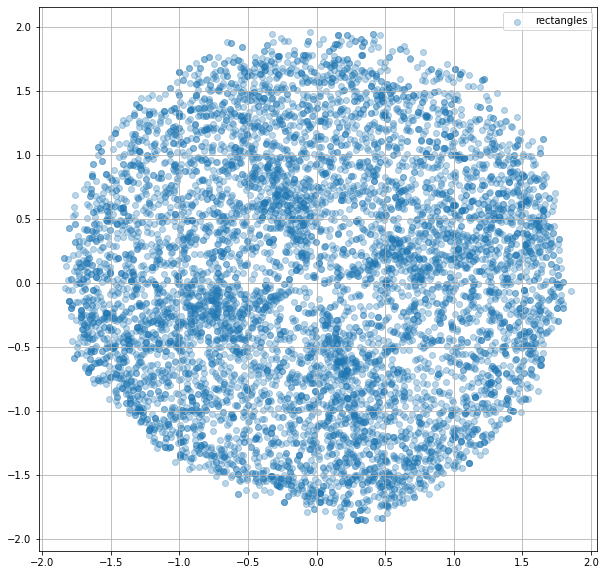

In [ ]:
# res = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(res[:8192, 0], res[:8192, 1], alpha=0.3, label='rectangles')
# plt.scatter(res[8192:, 0], res[8192:, 1], alpha=0.3, label='circles')

ax.legend()
ax.grid(True)

plt.show()

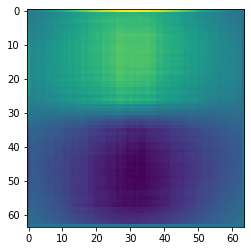

In [155]:
plt.imshow(pca.components_[0].reshape(64, 64))

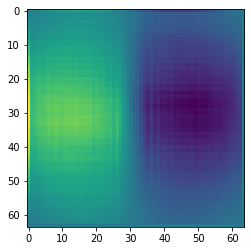

In [156]:
plt.imshow(pca.components_[1].reshape(64, 64))

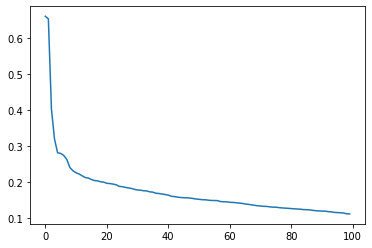

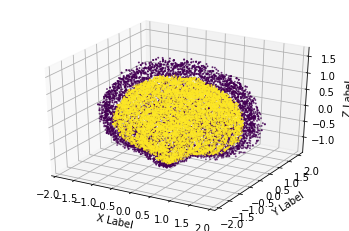

In [ ]:
res = PCA(n_components=3).fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(res[:, 0], res[:, 1], res[:, 2], c = [1] * 8192 + [2] * 8192, s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
class DecoderNET(nn.Module):
    def __init__(self):
        super(DecoderNET, self).__init__()

        self.l0 = nn.Linear(64 * 64, 2 * 100)

        self.l1 = nn.Linear(100, 3, bias = False)
        self.l2 = nn.Linear(100, 3, bias = False)

        self.activation = nn.Sigmoid()
            
    def forward(self, x):
        # x = self.activation(self.l0(x))
        x = self.l0(x)

        x1 = self.l1(x[:, :100])
        x1_= self.l2(x[:, :100])
        x2 = self.l2(x[:, 100:])
        x2_= self.l1(x[:, 100:])
        return x, x1, x2, x1_, x2_

In [ ]:
model = DecoderNET().cuda()

# Use Adam optimizer
opt = optim.Adam(model.parameters(), weight_decay=1e-2)

train_loss = []

In [ ]:
import time
import pandas as pd
from IPython import display
from sklearn.metrics import mean_squared_error

num_epochs = 100
val_acc_loss = []
val_all_loss = []

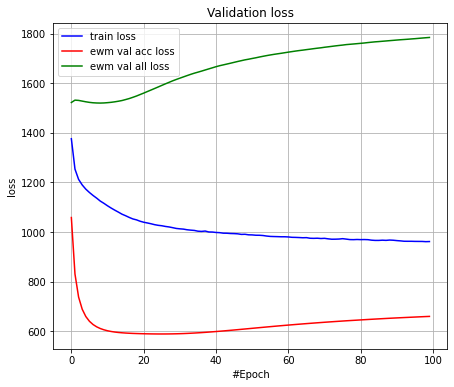

Epoch 100 of 100 took 0.528s
  training loss (in-iteration): 	961.526001


In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    for batch_list in zip(rect_loader, circ_loader):
        batch_loss = []
        X_rect_batch, y_rect_batch, X_circ_batch, y_circ_batch = map(lambda x: x.cuda(), [a for sub_list in batch_list for a in sub_list])

        # если круг
        latents, x1, x2, x1_, x2_ = model(X_circ_batch)
        loss = torch.norm(latents[:, 100:], dim=1).mean() + F.mse_loss(x1, y_circ_batch) + torch.norm(x1_) + torch.norm(x2)

        # если квадрат
        latents, x1, x2, x1_, x2_ = model(X_rect_batch)
        loss+= torch.norm(latents[:, :100], dim=1).mean() + F.mse_loss(x2, y_rect_batch) + torch.norm(x2_) + torch.norm(x1)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        batch_loss.append(loss.item())
    
    train_loss.append(np.mean(batch_loss))

    model.eval()

    for batch_list in zip(rect_val_loader, circ_val_loader):
        X_rect_batch, y_rect_batch, X_circ_batch, y_circ_batch = map(lambda x: x.cuda(), [a for sub_list in batch_list for a in sub_list])

        # если круг
        latents, x1, x2, x1_, x2_ = model(X_circ_batch)
        loss1 = torch.norm(latents[:, 100:], dim=1).mean() + torch.norm(x1_) + torch.norm(x2)
        loss2 = F.mse_loss(x1, y_circ_batch)

        # если квадрат
        latents, x1, x2, x1_, x2_ = model(X_rect_batch)
        loss1+= torch.norm(latents[:, :100], dim=1).mean() + torch.norm(x2_) + torch.norm(x1)
        loss2+= F.mse_loss(x2, y_rect_batch)
    
    val_acc_loss.append(loss2.item() )
    val_all_loss.append((loss1 + loss2).item() )
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(24, 6))
    ax1 = plt.subplot(131)
    ax1.set_title("Validation loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss, 'b',label='train loss')
    ax1.plot(pd.DataFrame(np.array(val_acc_loss)).ewm(span=10).mean(),'r',label='ewm val acc loss')
    ax1.plot(pd.DataFrame(np.array(val_all_loss)).ewm(span=10).mean(),'g',label='ewm val all loss')
    ax1.legend(loc='best')
    ax1.grid()

    plt.show()    
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1])) 
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    # print("  validation loss:\t\t{:.6f}".format(val_loss[-1]))

In [ ]:
print((y_rect_batch - sum(model(X_rect_batch)[1:])).std(0), (y_rect_batch - model(X_rect_batch)[2]).std(0))
print((y_circ_batch - sum(model(X_circ_batch)[1:])).std(0), (y_circ_batch - model(X_circ_batch)[1]).std(0))

tensor([0.9954, 5.4440, 6.0217], device='cuda:0', grad_fn=<StdBackward1>) tensor([ 3.3698, 10.9496, 11.0910], device='cuda:0', grad_fn=<StdBackward1>)
tensor([1.3251, 5.8543, 5.5382], device='cuda:0', grad_fn=<StdBackward1>) tensor([ 5.8205, 15.5552, 15.4873], device='cuda:0', grad_fn=<StdBackward1>)


In [ ]:
class SimpleNET(nn.Module):
    def __init__(self):
        super(SimpleNET, self).__init__()

        self.l0 = nn.Linear(64 * 64, 3)

        # self.l1 = nn.Linear(100, 3, bias = False)

        self.activation = nn.Sigmoid()
            
    def forward(self, x):
        # x = self.activation(self.l0(x))
        x = self.l0(x)
        # x = self.l1(x)
        return x

In [ ]:
model = SimpleNET().cuda()

# Use Adam optimizer
opt = optim.Adam(model.parameters(), weight_decay=1e-2)

num_epochs = 100
train_loss = []
val_acc_loss = []
val_all_loss = []

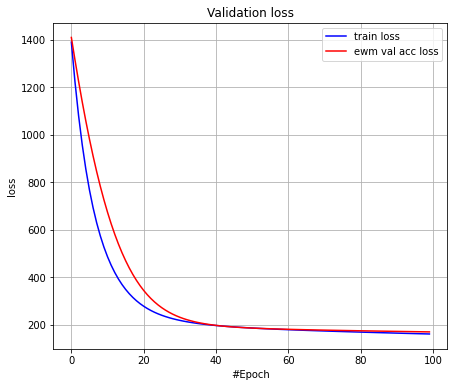

Epoch 100 of 100 took 0.443s
  training loss (in-iteration): 	160.479141


In [ ]:
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    for batch_list in zip(rect_loader, circ_loader):
        batch_loss = []
        X_rect_batch, y_rect_batch, X_circ_batch, y_circ_batch = map(lambda x: x.cuda(), [a for sub_list in batch_list for a in sub_list])

        # если круг
        x = model(X_circ_batch)
        loss = F.mse_loss(x, y_circ_batch)

        # если квадрат
        x = model(X_rect_batch)
        loss+= F.mse_loss(x, y_rect_batch)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        batch_loss.append(loss.item())
    
    train_loss.append(np.mean(batch_loss))

    model.eval()

    for batch_list in zip(rect_val_loader, circ_val_loader):
        X_rect_batch, y_rect_batch, X_circ_batch, y_circ_batch = map(lambda x: x.cuda(), [a for sub_list in batch_list for a in sub_list])

        # если круг
        x = model(X_circ_batch)
        loss2 = F.mse_loss(x, y_circ_batch)

        # если квадрат
        x = model(X_rect_batch)
        loss2+= F.mse_loss(x, y_rect_batch)
    
    val_acc_loss.append(loss2.item() )
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(24, 6))
    ax1 = plt.subplot(131)
    ax1.set_title("Validation loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss, 'b',label='train loss')
    ax1.plot(pd.DataFrame(np.array(val_acc_loss)).ewm(span=10).mean(),'r',label='ewm val acc loss')
    ax1.legend(loc='best')
    ax1.grid()

    plt.show()    
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_loss[-1])) 
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
    # print("  validation loss:\t\t{:.6f}".format(val_loss[-1]))

In [ ]:
print((y_rect_batch - model(X_rect_batch)).std(0) )
print((y_circ_batch - model(X_circ_batch)).std(0) )

tensor([ 0.4891, 10.5778, 10.8257], device='cuda:0', grad_fn=<StdBackward1>)
tensor([ 0.3892, 10.9104, 10.3526], device='cuda:0', grad_fn=<StdBackward1>)


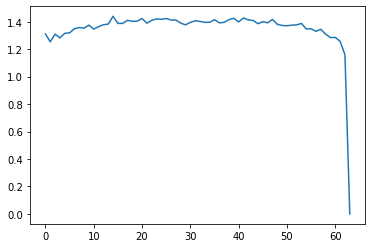

In [ ]:
plt.plot(model.l0.weight[0].reshape(64, 64).norm(dim=0).cpu().detach().numpy())

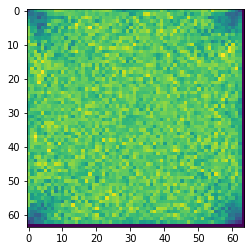

In [ ]:
plt.imshow(model.l0.weight[0].reshape(64, 64).cpu().detach().numpy())